### 🔑 Authenticate & Download Data


In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d phucthaiv02/butterfly-image-classification
!unzip -o butterfly-image-classification.zip -d /content/butterfly_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/butterfly_data/train/Image_2348.jpg  
  inflating: /content/butterfly_data/train/Image_2349.jpg  
  inflating: /content/butterfly_data/train/Image_235.jpg  
  inflating: /content/butterfly_data/train/Image_2350.jpg  
  inflating: /content/butterfly_data/train/Image_2351.jpg  
  inflating: /content/butterfly_data/train/Image_2352.jpg  
  inflating: /content/butterfly_data/train/Image_2353.jpg  
  inflating: /content/butterfly_data/train/Image_2354.jpg  
  inflating: /content/butterfly_data/train/Image_2355.jpg  
  inflating: /content/butterfly_data/train/Image_2356.jpg  
  inflating: /content/butterfly_data/train/Image_2357.jpg  
  inflating: /content/butterfly_data/train/Image_2358.jpg  
  inflating: /content/butterfly_data/train/Image_2359.jpg  
  inflating: /content/butterfly_data/train/Image_236.jpg  
  inflating: /content/butterfly_data/train/Image_2360.jpg  
  inflating: /content/butterfly_data/train/Image_23

## 🏗️ Building & Evaluating the CNN Model


Top 10 most frequent classes: ['MOURNING CLOAK', 'SLEEPY ORANGE', 'ATALA', 'BROWN SIPROETA', 'SCARCE SWALLOW', 'CRECENT', 'BANDED ORANGE HELICONIAN', 'MILBERTS TORTOISESHELL', 'RED CRACKER', 'ORANGE TIP']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1523 - loss: 2.2759 - val_accuracy: 0.2656 - val_loss: 2.0908
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3564 - loss: 1.9912 - val_accuracy: 0.6033 - val_loss: 1.5586
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5875 - loss: 1.3661 - val_accuracy: 0.6492 - val_loss: 1.1094
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7238 - loss: 0.9419 - val_accuracy: 0.6885 - val_loss: 0.9366
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7744 - loss: 0.7264 - val_accuracy: 0.6164 - val_loss: 1.0473
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8042 - loss: 0.6571 - val_accuracy: 0.6951 - val_loss: 0.8854
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8171 - loss: 0.5873 - val_accuracy: 0.7443 - val_loss: 0.7248
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8943 - loss: 0.4335 - val_accuracy: 0.7475 - val_loss:

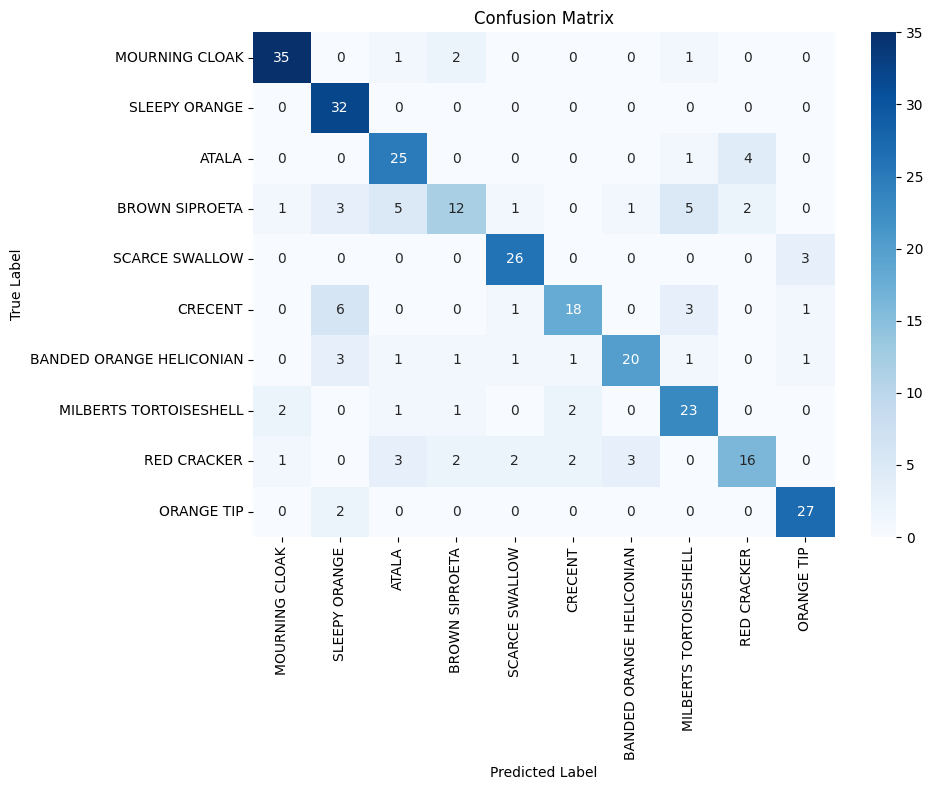

88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step

— Final Test Predictions —
      filename         predicted_label
0  Image_1.jpg          SCARCE SWALLOW
1  Image_2.jpg             RED CRACKER
2  Image_3.jpg              ORANGE TIP
3  Image_4.jpg  MILBERTS TORTOISESHELL
4  Image_5.jpg  MILBERTS TORTOISESHELL


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Paths
TRAIN_DIR = '/content/butterfly_data/train'
TEST_DIR = '/content/butterfly_data/test'
TRAIN_CSV = '/content/butterfly_data/Training_set.csv'
TEST_CSV = '/content/butterfly_data/Testing_set.csv'

# 2. Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
train_df.columns = train_df.columns.str.strip().str.lower()
test_df.columns = test_df.columns.str.strip().str.lower()

if 'filename' not in train_df.columns or 'label' not in train_df.columns:
    raise ValueError("Training CSV must contain 'filename' and 'label' columns.")

# 3. Filter top 10 classes
top_classes = train_df['label'].value_counts().head(10).index.tolist()
print("Top 10 most frequent classes:", top_classes)
train_df = train_df[train_df['label'].isin(top_classes)].reset_index(drop=True)

# 4. Load and preprocess images for CNN
def load_images_cnn(df, folder, classes, size=(128, 128)):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(folder, row['filename'])
        try:
            img = load_img(img_path, target_size=size)
            arr = img_to_array(img) / 255.0
            X.append(arr)
            y.append(classes.index(row['label']))
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(X), to_categorical(np.array(y), num_classes=len(classes))

# Load training data
X, y = load_images_cnn(train_df, TRAIN_DIR, top_classes)

# 5. Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 6. Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(top_classes), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 7. Train CNN
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val))

# 8. Evaluation
val_preds = model.predict(X_val)
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(val_preds, axis=1)

# Classification report
print("\n— Validation Set Classification Report —")
print(classification_report(y_val_true, y_val_pred, target_names=top_classes))

# Confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_classes, yticklabels=top_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 9. Process and predict test images
def load_test_images_cnn(df, folder, size=(128, 128)):
    X = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder, row['filename'])
        try:
            img = load_img(img_path, target_size=size)
            arr = img_to_array(img) / 255.0
            X.append(arr)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(X)

X_test_final = load_test_images_cnn(test_df, TEST_DIR)
test_preds = model.predict(X_test_final)
test_df['predicted_label'] = [top_classes[i] for i in np.argmax(test_preds, axis=1)]
test_df.to_csv('/content/test_with_predictions_cnn.csv', index=False)

print("\n— Final Test Predictions —")
print(test_df[['filename', 'predicted_label']].head())
